In [1]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
from torch_geometric.utils import to_dense_adj
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as Fqb
from rdkit import Chem
from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
from mappings import *

import mappings
from test import *

2.0.1
2.0.1


In [2]:
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)

[12:11:12] WARNING: no name column found on line 0
[12:11:12] WARNING: no name column found on line 1
[12:11:12] WARNING: no name column found on line 2
[12:11:12] WARNING: no name column found on line 3
[12:11:12] WARNING: no name column found on line 4
[12:11:12] WARNING: no name column found on line 5
[12:11:12] WARNING: no name column found on line 6
[12:11:12] WARNING: no name column found on line 7
[12:11:12] WARNING: no name column found on line 8
[12:11:12] WARNING: no name column found on line 9
[12:11:12] WARNING: no name column found on line 10
[12:11:12] WARNING: no name column found on line 11
[12:11:12] WARNING: no name column found on line 12
[12:11:12] WARNING: no name column found on line 13
[12:11:12] WARNING: no name column found on line 14
[12:11:12] WARNING: no name column found on line 15
[12:11:12] WARNING: no name column found on line 16
[12:11:12] WARNING: no name column found on line 17
[12:11:12] WARNING: no name column found on line 18
[12:11:12] WARNING: no

In [3]:
train_data = rdkit2pyg(train_guac_mols[:32]) 
len(train_data)

32

In [4]:
max_n = 0
for g in train_data: 
    if g.x.shape[0] > max_n:
        max_n = g.x.shape[0]

mappings.max_num_node = max_n
mappings.max_prev_node = mappings.max_num_node - 1
valid_data = train_data
# atom2num, num2atom, max_num_node = get_atoms_info(guac_mols)
#!-------------------------------------------

#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 
#!-------------------------------------------

#! --- SET UP EXPERIMENT ---
LRrnn, LRout = 1e-2, 1e-2
# wd = 5e-4
epoch, max_epoch = 1, 5001
device, cuda, train_log, val_log = setup()
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, valid_data, max_num_node, max_prev_node) #! HERE WORKERS
rnn, output = get_generator()
optimizer_rnn = torch.optim.RMSprop(list(rnn.parameters()), lr=LRrnn) # , eps=1e-5)  # , weight_decay=wd)
optimizer_output = torch.optim.RMSprop(list(output.parameters()), lr=LRout) #, eps=1e-5)  # , weight_decay=wd)

scheduler_rnn = torch.optim.lr_scheduler.OneCycleLR(optimizer_rnn, max_lr=LRrnn, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
scheduler_output = torch.optim.lr_scheduler.OneCycleLR(optimizer_output, max_lr=LRout, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)


In [5]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists = {}
activations = {}
grads = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists[f'{name}_output_{idx}'] = []
            layer_hists[f'{name}_hidden_{idx}'] = []
            activations[f'{name}_output_{idx}'] = []
            activations[f'{name}_hidden_{idx}'] = []            
    else:
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists[name] = []
        activations[name] = []
        grads[name] = []

In [6]:
# layer_means_rnn, layer_stds_rnn

In [7]:
def backward_append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        pass
    else:    
        grads[name].append(output[0].grad.detach().cpu().numpy())

In [8]:
def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].detach().cpu().numpy().std())
        layer_hists[f'{name}_output_{idx}'].append(output[0].detach().cpu().abs().histc(40,0,10))
        layer_hists[f'{name}_hidden_{idx}'].append(output[1].detach().cpu().abs().histc(40,0,10))
    else:
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists[name].append(output.detach().cpu().abs().histc(40,0,10))
        activations[name].append(output.detach().cpu().numpy())


In [9]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))
    # module.register_backward_hook(partial(backward_append_, idx, module_name))

In [10]:
gradients={}
for name, param in rnn.named_parameters():
    gradients[name] = []

# for name, param in output.named_parameters():
#     gradients[name] = []



In [11]:
epoch = 0
update = []

while epoch <= 75:
    loss_this_epoch, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                                            data_loader_=train_dataset_loader,
                                                            optimizer_rnn=optimizer_rnn, optimizer_output=optimizer_output,
                                                            node_weights=node_weights, edge_weights=edge_weights)
    for name, param in rnn.named_parameters():
        gradients[name].append(param.grad.detach().cpu().numpy())

    update.append([(optimizer_rnn.param_groups[0]['lr']* p.grad.std()/p.data.std()).log10().item() for p in rnn.parameters()])

    epoch +=1

AttributeError: 'tuple' object has no attribute 'detach'

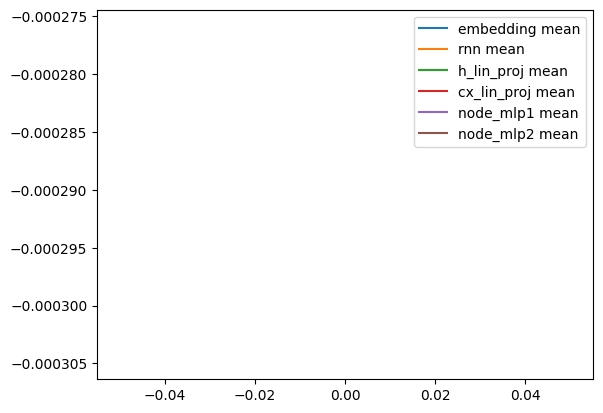

In [14]:
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')

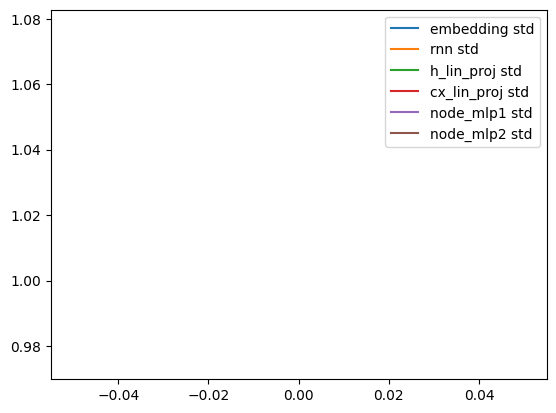

In [15]:
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} std'.format(i=color))
plt.legend(loc='best')

RuntimeError: stack expects a non-empty TensorList

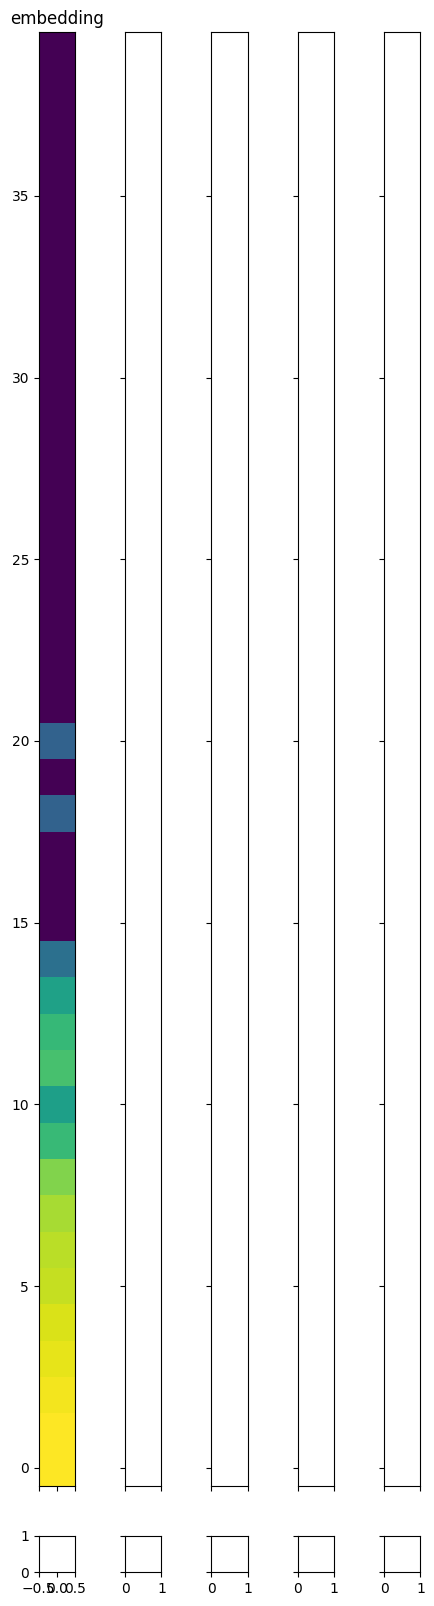

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): 
    return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

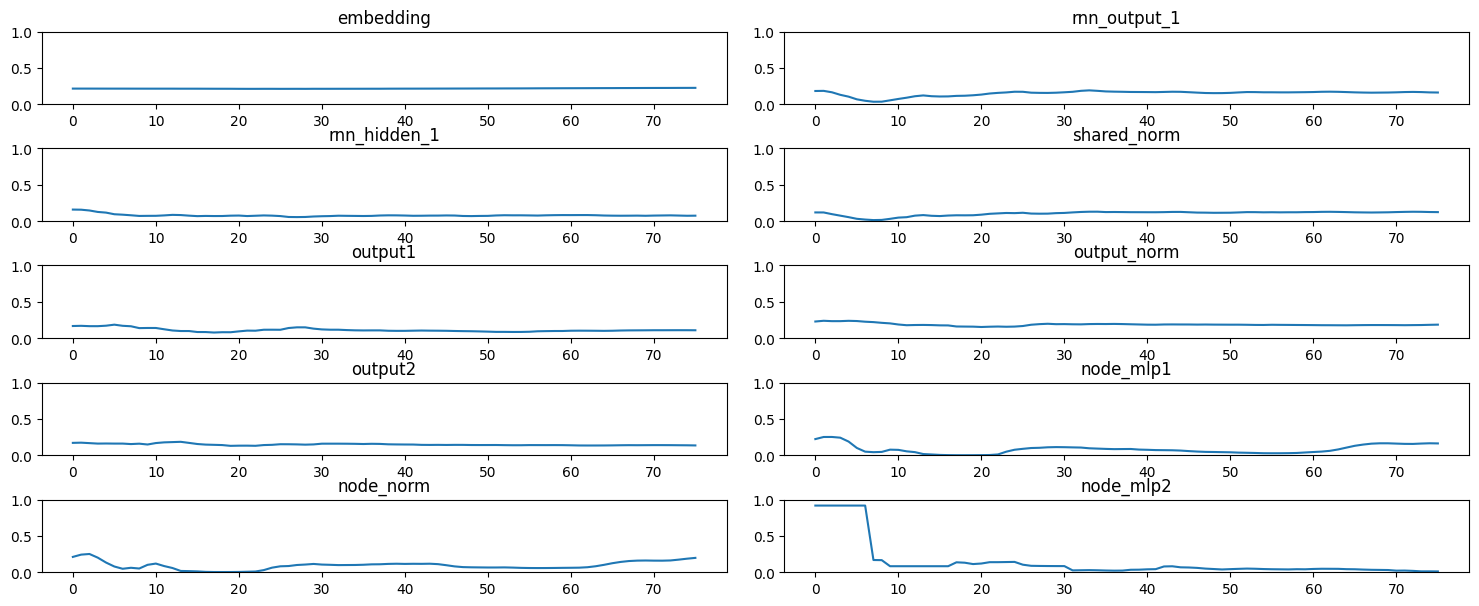

In [ ]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(5,2, figsize=(15, 6))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists.keys())):
    h = layer_hists[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

/home/nobilm@usi.ch/miniconda3/envs/graphRNN_venv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'activation distribution')

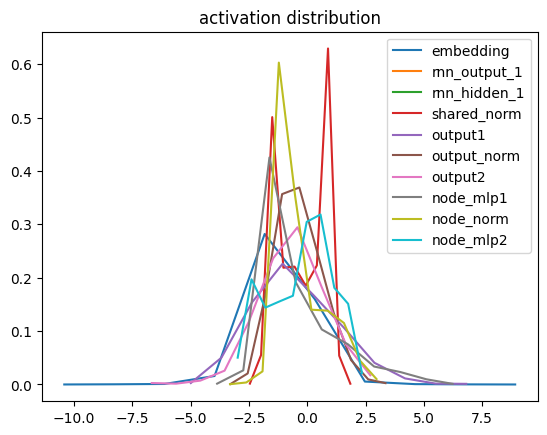

In [ ]:
legends = []
for k in activations.keys():
    hy, hx = np.histogram(activations[k], density = True)
    plt.plot(hx[:-1], hy)
    legends.append(k)

plt.legend(legends)
plt.title('activation distribution')

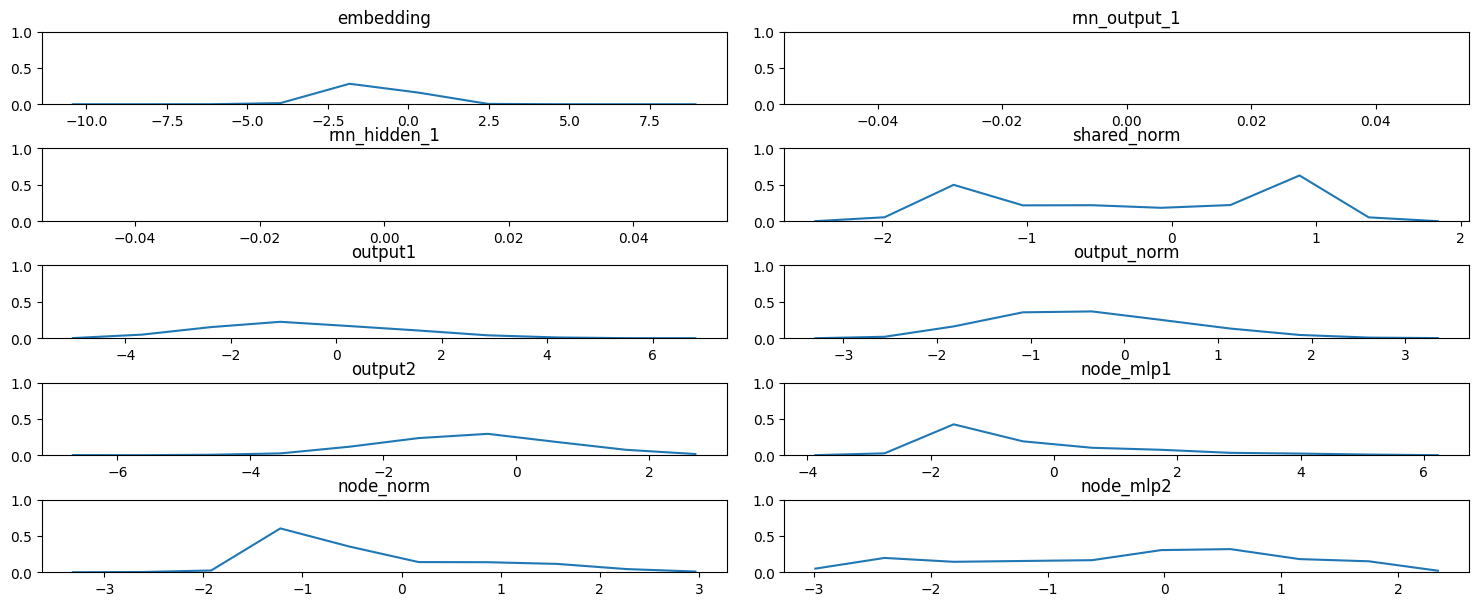

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(15, 6))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(activations.keys())):
    hy, hx = np.histogram(activations[k], density = True)
    ax.plot(hx[:-1], hy)
    ax.set_title(k)
    ax.set_ylim(0,1)

In [ ]:
len(update)

76

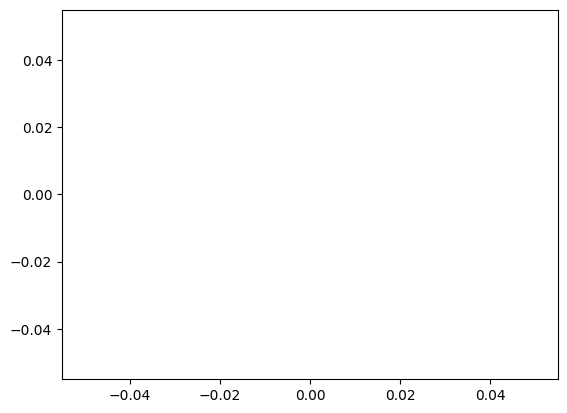

In [17]:
plt.plot([update[j] for j in range(len(update))])


In [18]:
# sum()/len(gradients['embedding.weight'])
x =np.zeros_like(gradients['embedding.weight'][0])
for i in gradients['embedding.weight']:
    x+=i

IndexError: list index out of range

In [19]:
plt.plot(x.sum(1))

NameError: name 'x' is not defined